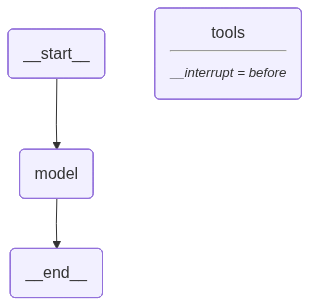

In [14]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, List,Annotated
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from IPython.display import Image,display


memory = MemorySaver()
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)
search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]
llm_with_tools = llm.bind_tools(tools=tools)


class BasicState(TypedDict):
    messages:Annotated[List,add_messages]

def model(state:BasicState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }


def tools_router(state: BasicState): 
    last_message = state["messages"][-1]
    should_continue = input("Do you want to continue? (y/n): ")
    if should_continue.lower() != 'y':
        return END
    if(hasattr(last_message, "tool_calls") and 
    len(last_message.tool_calls) > 0):
        return "tools"
    else: 
        return END   


graph = StateGraph(BasicState)
graph.add_node(model, "model")
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("model")
graph.add_edge("tools", "model")

graph.add_conditional_edges("model", tools_router)


app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

display(Image(app.get_graph().draw_mermaid_png()))

config = {"configurable": {
    "thread_id": 1
}}

events = app.stream({
    "messages": [HumanMessage(content="What is the current weather in Chennai?")]
}, config=config, stream_mode="values")



for event in events:
    event["messages"][-1].pretty_print()